# 단어 문서 행렬(Term Document Matrix)
- 문서별로 단어의 빈도를 정리한 행렬
- 비정형 데이터인 텍스트를 행렬 형태로 정형화
- BOW(Bag of Words)
    - 문서가 가지는 모든 단어(Words)를 문맥이나 순서를 무시하고 일괄적으로 단어에 대해 빈도 값을 부여해 피처 값을 추출하는 방법


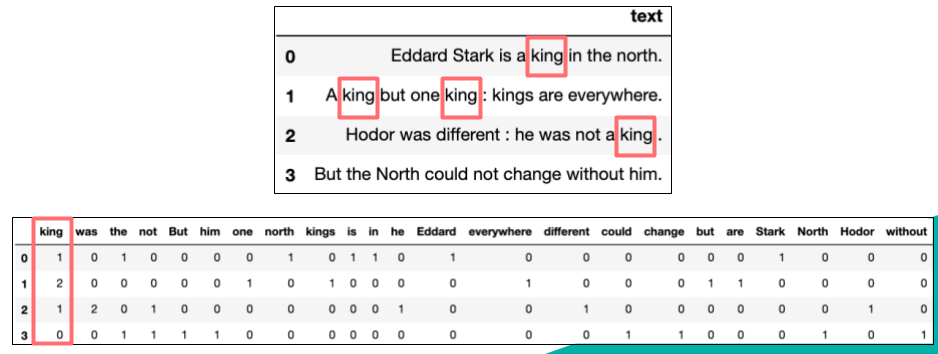

In [1]:
# 구글 코랩에서
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [2]:
# 현재 작업 디렉토리 확인
os.getcwd()

'c:\\study\\04_NLP'

In [3]:

DATA_PATH = os.getcwd()
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

- imdb_dataset
    - 영화 리뷰 데이터셋
    - 영화 리뷰에 대해 긍정/부정을 예측하는 데이터셋

In [5]:
df = pd.read_csv(os.path.join(DATA_PATH, 'data','imdb_dataset.csv'))
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


- 긍정:1, 부정:0

In [7]:
df["sentiment"] = (df["sentiment"] == "positive").astype(int)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [8]:
df["sentiment"].value_counts(normalize=True)


sentiment
1    0.5
0    0.5
Name: proportion, dtype: float64

- 정답데이터

In [9]:
target = df["sentiment"].to_numpy().reshape(-1,1)
target.shape

(50000, 1)

In [10]:
target.mean()

0.5

In [3]:
def preprocess(text):
    import numpy as np
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [4]:
preprocess("04_LDA와 LSA 피처로 활용하기.ipynb")

(array([0, 1, 2, 3, 4]),
 {'04_lda와': 0, 'lsa': 1, '피처로': 2, '활용하기': 3, '.ipynb': 4},
 {0: '04_lda와', 1: 'lsa', 2: '피처로', 3: '활용하기', 4: '.ipynb'})

In [19]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    import numpy as np
    '''동시발생 행렬 생성

    :param corpus: 말뭉치(단어 ID 목록)
    :param vocab_size: 어휘 수
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return: 동시발생 행렬
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):

            print(idx,i)

            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                print("left_idx opper")
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                print("right_idx opper")
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

In [20]:
import numpy as np
C=np.random.randint(0,high=5,size=(5, 4))
create_co_matrix(C,len(C))

0 1
right_idx opper
1 1
left_idx opper
right_idx opper
2 1
left_idx opper
right_idx opper
3 1
left_idx opper
right_idx opper
4 1
left_idx opper


array([[0, 1, 1, 0, 0],
       [1, 2, 1, 2, 2],
       [1, 1, 2, 1, 4],
       [0, 2, 1, 2, 0],
       [0, 2, 4, 0, 0]])

## CountVectorizer
- max_features
    - 빈도순으로 문서별로 몇개의 단어의 빈도를 추출할건지
- stop_words
    - 제외 하고자 하는 불용어 리스트를 전달

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
cnt_vec = CountVectorizer(max_features=100, stop_words="english")
tdm = cnt_vec.fit_transform(df["review"])
tdm

<50000x100 sparse matrix of type '<class 'numpy.int64'>'
	with 835323 stored elements in Compressed Sparse Row format>

In [13]:
tdm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [14]:
cnt_vec.get_feature_names_out() # TDM 에 컬럼명

array(['10', 'acting', 'action', 'actors', 'actually', 'away', 'bad',
       'best', 'better', 'big', 'bit', 'br', 'cast', 'character',
       'characters', 'come', 'comedy', 'did', 'didn', 'director', 'does',
       'doesn', 'don', 'end', 'fact', 'family', 'far', 'feel', 'film',
       'films', 'fun', 'funny', 'gets', 'girl', 'going', 'good', 'got',
       'great', 'guy', 'horror', 'interesting', 'isn', 'just', 'kind',
       'know', 'life', 'like', 'little', 'll', 'long', 'look', 'lot',
       'love', 'make', 'makes', 'making', 'man', 'minutes', 'movie',
       'movies', 'music', 'new', 'old', 'original', 'people',
       'performance', 'plot', 'point', 'pretty', 'probably', 'quite',
       'real', 'really', 'right', 'role', 'saw', 'say', 'scene', 'scenes',
       'script', 'seen', 'series', 'story', 'thing', 'things', 'think',
       'thought', 'time', 'times', 'tv', 've', 'want', 'watch',
       'watching', 'way', 'woman', 'work', 'world', 'years', 'young'],
      dtype=object)

- 문서별로 단어(토큰) 분리 기준을 지정할 수 있다.

In [15]:
cnt_vec = CountVectorizer(max_features=100, tokenizer= lambda x : x.split(",") , token_pattern=None)
cnt_vec.fit(df["review"])
cnt_vec.get_feature_names_out()

array(['', ' acting', ' action', ' after all', ' again', ' and',
       ' and of course', ' and yes', ' apparently', ' as always',
       ' as usual', ' at least', ' at times', ' bad', ' bad acting',
       ' because', ' boring', ' but', ' but hey', ' but then again',
       ' by the way', ' cinematography', ' comedy', ' costumes',
       ' directing', ' direction', ' director', ' drama', ' drugs',
       ' dull', ' editing', ' etc', ' etc.', ' etc.)', ' for example',
       ' for instance', ' for me', ' for the most part', ' funny',
       ' however', ' i guess', ' i mean', ' i think', ' i thought',
       ' in fact', ' in my opinion', ' in particular', ' in the end',
       ' indeed', ' jr.', ' like me', ' love', ' maybe', ' music',
       ' naturally', ' no', ' of course', ' oh', ' on the other hand',
       ' or', ' perhaps', ' please', ' really', ' romance', ' sad',
       ' sadly', ' say', ' script', ' sex', ' sexy', ' so', ' sure',
       ' suspense', ' that is', ' the acting', 

In [16]:
cnt_vec = CountVectorizer(max_features=100, stop_words="english")
tmp = cnt_vec.fit_transform(df["review"])
tmp

<50000x100 sparse matrix of type '<class 'numpy.int64'>'
	with 835323 stored elements in Compressed Sparse Row format>

In [17]:
cnt_vec.get_feature_names_out()

array(['10', 'acting', 'action', 'actors', 'actually', 'away', 'bad',
       'best', 'better', 'big', 'bit', 'br', 'cast', 'character',
       'characters', 'come', 'comedy', 'did', 'didn', 'director', 'does',
       'doesn', 'don', 'end', 'fact', 'family', 'far', 'feel', 'film',
       'films', 'fun', 'funny', 'gets', 'girl', 'going', 'good', 'got',
       'great', 'guy', 'horror', 'interesting', 'isn', 'just', 'kind',
       'know', 'life', 'like', 'little', 'll', 'long', 'look', 'lot',
       'love', 'make', 'makes', 'making', 'man', 'minutes', 'movie',
       'movies', 'music', 'new', 'old', 'original', 'people',
       'performance', 'plot', 'point', 'pretty', 'probably', 'quite',
       'real', 'really', 'right', 'role', 'saw', 'say', 'scene', 'scenes',
       'script', 'seen', 'series', 'story', 'thing', 'things', 'think',
       'thought', 'time', 'times', 'tv', 've', 'want', 'watch',
       'watching', 'way', 'woman', 'work', 'world', 'years', 'young'],
      dtype=object)

In [18]:
tdm_df = pd.DataFrame( tmp.toarray(), columns=cnt_vec.get_feature_names_out() )
tdm_df

,10,acting,action,actors,actually,away,bad,best,better,big,...,ve,want,watch,watching,way,woman,work,world,years,young
0,0,0,0,0,0,2,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,1,0,0,1,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,0,1,0,1,...,0,0,1,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
49996,0,1,0,0,0,0,4,0,2,0,...,0,1,2,0,0,0,0,0,0,0
49997,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [19]:
tdm_df.sum().sort_values()

woman      5341
fun        5392
girl       5495
away       5509
kind       5548
          ...  
just      35184
like      40172
film      79705
movie     87971
br       201951
Length: 100, dtype: int64

In [20]:
tdm_df.sum().to_dict()

{'10': 8614,
 'acting': 12867,
 'action': 6497,
 'actors': 8951,
 'actually': 8470,
 'away': 5509,
 'bad': 18473,
 'best': 12612,
 'better': 11430,
 'big': 6962,
 'bit': 5967,
 'br': 201951,
 'cast': 7426,
 'character': 13905,
 'characters': 14456,
 'come': 6290,
 'comedy': 6576,
 'did': 12624,
 'didn': 8768,
 'director': 8812,
 'does': 11627,
 'doesn': 8876,
 'don': 17623,
 'end': 11121,
 'fact': 6902,
 'family': 5884,
 'far': 5994,
 'feel': 5835,
 'film': 79705,
 'films': 13755,
 'fun': 5392,
 'funny': 8758,
 'gets': 6236,
 'girl': 5495,
 'going': 8190,
 'good': 29753,
 'got': 6949,
 'great': 18144,
 'guy': 6390,
 'horror': 7250,
 'interesting': 6180,
 'isn': 6318,
 'just': 35184,
 'kind': 5548,
 'know': 12510,
 'life': 12917,
 'like': 40172,
 'little': 12435,
 'll': 5795,
 'long': 6885,
 'look': 8295,
 'lot': 8085,
 'love': 13008,
 'make': 15899,
 'makes': 8312,
 'making': 5779,
 'man': 11823,
 'minutes': 5871,
 'movie': 87971,
 'movies': 15309,
 'music': 6470,
 'new': 8096,
 'old':

## 단어구름 만들어 시각화

- 불용어 리스트 전달해서 제외하기

In [21]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words = list(ENGLISH_STOP_WORDS)
stop_words.append("br")
stop_words.append("10")

In [22]:
cnt_vec = CountVectorizer(max_features=100, stop_words=stop_words)
tmp = cnt_vec.fit_transform(df["review"])
tdm_df = pd.DataFrame(tmp.toarray(), columns=cnt_vec.get_feature_names_out())

In [23]:
from wordcloud import WordCloud
wc = WordCloud(width=500, height=500, background_color="white")

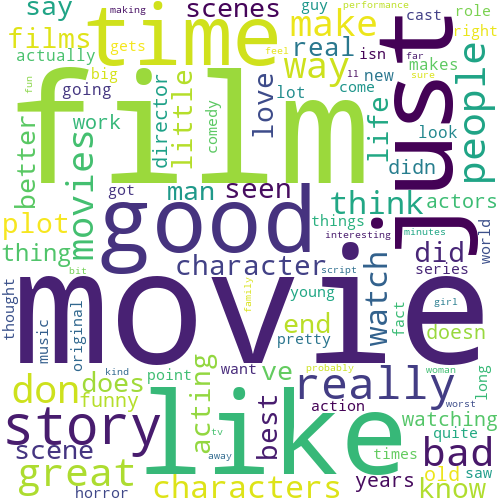

In [24]:
cloud = wc.generate_from_frequencies(tdm_df.sum().to_dict())
cloud.to_image()

## TF-IDF
- 단어 빈도(TF) 와 역문서 빈도(IDF) 곱한값
- 단어 빈도에 가중치를 주는 방법
- 문서빈도(DF): 각 단어가 등장한 문서 수
- 역문서 빈도(IDF): 총 문서 수를 DF로 나눈 값

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(max_features=100, stop_words=stop_words)
tmp = tfidf_vec.fit_transform(df["review"])
tmp

<50000x100 sparse matrix of type '<class 'numpy.float64'>'
	with 808479 stored elements in Compressed Sparse Row format>

In [26]:
tfidf_df = pd.DataFrame( tmp.toarray(), columns=tfidf_vec.get_feature_names_out() )
tfidf_df

,acting,action,actors,actually,away,bad,best,better,big,bit,...,want,watch,watching,way,woman,work,world,worst,years,young
0,0.000000,0.000000,0.000000,0.0,0.362587,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.312702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.272614,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.268270,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.199503,0.168985,0.244110,0.000000,0.000000,0.000000,0.204344,0.224635
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.150056,0.200933,0.000000,0.0,0.000000,0.000000,0.156014,0.000000,0.187944,0.0,...,0.000000,0.148908,0.000000,0.144133,0.000000,0.176151,0.188154,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.157229,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
49996,0.169262,0.000000,0.000000,0.0,0.000000,0.651161,0.000000,0.357836,0.000000,0.0,...,0.206193,0.335936,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
49997,0.200962,0.000000,0.000000,0.0,0.000000,0.193278,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
49998,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.392803,0.000000,0.000000,0.000000,0.000000,0.000000


# Similarity(유사도)

## 자카드 유사도(jaccard similarity)
- 교집합의 크기 / 합집합 크기

In [27]:
def jaccard_similarity(text1, text2):
    text1 = text1.split()
    text2 = text2.split()

    # 중복단어 제거
    text1 = set(text1)
    text2 = set(text2)

    # 교집합 단어 개수 구하기
    intersection_len = len( set.intersection(text1, text2) )

    # 합집합 단어 개수 구하기
    union_len = len( set.union(text1, text2) )
    return intersection_len / union_len

In [28]:
jaccard_similarity(df["review"][1], df["review"][2])

0.10849056603773585

## 코사인 유사도(cosine similarity)
- 코사인 유사도는 두 벡터 간의 코사인 각도를 이용하여 구할 수 있는 유사도
- 문서의 유사도를 구할 때 많이 사용
- -1 ~ 1 사이 값을 가지며, 1에 가까울 수록 유사도가 높다고 판단

$$
{\displaystyle {\text{similarity}}=\cos(\theta )={A\cdot B \over \|A\|\|B\|}={\frac {\sum \limits _{i=1}^{n}{A_{i}\times B_{i}}}{{\sqrt {\sum \limits _{i=1}^{n}{(A_{i})^{2}}}}\times {\sqrt {\sum \limits _{i=1}^{n}{(B_{i})^{2}}}}}}}
$$

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

In [30]:
cosine_similarity(tdm_df.iloc[:1] , tdm_df.iloc[1:2]) # 2차원 형태로 전달해야함.

array([[0.16979054]])

In [31]:
cosine_similarity(tdm_df.iloc[:1] , tdm_df.iloc[1:]) # 0번 샘플과 다른 샘플들 간에 유사도 구해보기

array([[0.16979054, 0.20567735, 0.13151919, ..., 0.09863939, 0.        ,
        0.22933193]])

- 머신러닝 모델에 학습 시켜보기

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
model = LogisticRegression(random_state=SEED)

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(tdm_df)
x_train.shape

(50000, 100)

In [34]:

scores = cross_val_score(model, x_train, target, cv=cv, scoring="accuracy")

c:\Users\hopio\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hopio\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hopio\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\hopio\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

In [35]:
scores.mean()

0.74292

In [36]:
tdm_df

,acting,action,actors,actually,away,bad,best,better,big,bit,...,want,watch,watching,way,woman,work,world,worst,years,young
0,0,0,0,0,2,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,1,0,1,0,...,0,1,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
49996,1,0,0,0,0,4,0,2,0,0,...,1,2,0,0,0,0,0,0,0,0
49997,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [37]:
tdm_df.loc[:,'acting'].value_counts(normalize=True)

acting
0    0.78608
1    0.17950
2    0.02754
3    0.00544
4    0.00094
5    0.00036
6    0.00012
8    0.00002
Name: proportion, dtype: float64

In [38]:
col_50=[col for col in tdm_df.columns if (tdm_df[col].value_counts(normalize=True) >= 0.5).any()]
# 각 열에서 어떤 값이 50% 이상 빈도를 차지하는 열만 가져오는 것
len(col_50),col_50

(98,
 ['acting',
  'action',
  'actors',
  'actually',
  'away',
  'bad',
  'best',
  'better',
  'big',
  'bit',
  'cast',
  'character',
  'characters',
  'come',
  'comedy',
  'did',
  'didn',
  'director',
  'does',
  'doesn',
  'don',
  'end',
  'fact',
  'family',
  'far',
  'feel',
  'films',
  'fun',
  'funny',
  'gets',
  'girl',
  'going',
  'good',
  'got',
  'great',
  'guy',
  'horror',
  'interesting',
  'isn',
  'just',
  'kind',
  'know',
  'life',
  'like',
  'little',
  'll',
  'long',
  'look',
  'lot',
  'love',
  'make',
  'makes',
  'making',
  'man',
  'minutes',
  'movies',
  'music',
  'new',
  'old',
  'original',
  'people',
  'performance',
  'plot',
  'point',
  'pretty',
  'probably',
  'quite',
  'real',
  'really',
  'right',
  'role',
  'saw',
  'say',
  'scene',
  'scenes',
  'script',
  'seen',
  'series',
  'story',
  'sure',
  'thing',
  'things',
  'think',
  'thought',
  'time',
  'times',
  'tv',
  've',
  'want',
  'watch',
  'watching',
  'way'

In [39]:
tdm_df[col_50]

,acting,action,actors,actually,away,bad,best,better,big,bit,...,want,watch,watching,way,woman,work,world,worst,years,young
0,0,0,0,0,2,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,1,0,1,0,...,0,1,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
49996,1,0,0,0,0,4,0,2,0,0,...,1,2,0,0,0,0,0,0,0,0
49997,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [40]:
from sklearn.decomposition import TruncatedSVD
selected_data = tdm_df[col_50]

n_components = min(selected_data.shape) - 1  # SVD 컴포넌트 수 설정
svd = TruncatedSVD(n_components=n_components)
svd_result = svd.fit_transform(selected_data)

svd_df = pd.DataFrame(svd_result, columns=[f'SVD_{i+1}' for i in range(n_components)])

svd_df

,SVD_1,SVD_2,SVD_3,SVD_4,SVD_5,SVD_6,SVD_7,SVD_8,SVD_9,SVD_10,...,SVD_88,SVD_89,SVD_90,SVD_91,SVD_92,SVD_93,SVD_94,SVD_95,SVD_96,SVD_97
0,1.832199,0.612294,-1.239214,-1.201361,-0.205303,0.383747,-0.085080,-0.008734,-0.186902,-0.037116,...,0.679095,0.094537,0.121447,0.235456,-0.478101,-0.157213,-0.619032,-0.854440,0.191420,1.052184
1,1.306850,-0.715737,0.196858,-0.186105,0.550989,0.017694,0.919235,0.689434,0.063380,-0.057551,...,0.094403,0.005675,0.133507,-0.077585,-0.127448,0.073380,0.033241,0.007517,0.023256,-0.025745
2,1.557201,-0.904307,0.355029,-0.518704,0.815581,0.422282,0.273584,0.394201,-0.269365,0.172187,...,-0.228206,-0.025292,-0.177075,-0.028472,-0.237008,0.127612,-0.011425,0.220990,0.104696,0.018576
3,1.761662,0.755168,-0.180511,-1.284145,-0.401127,0.812439,-0.177573,0.224550,0.428295,-0.372423,...,-0.089621,-0.095094,-0.005475,0.016029,-0.069625,-0.019052,0.044862,0.058868,-0.002259,-0.015509
4,3.122022,-1.484727,0.128524,0.428357,1.316219,1.265179,0.174187,-1.724763,1.188063,-0.242258,...,0.121599,0.026277,-0.086903,0.410247,0.378500,0.635121,-0.209233,0.138147,0.156764,-0.294688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,3.554165,1.544566,-0.318764,-0.215145,-0.412478,0.655476,0.566972,-1.138189,0.134772,1.474145,...,-0.107997,-0.015940,0.052649,-0.215192,0.046958,0.222483,0.223094,0.533438,-0.671853,-0.159312
49996,1.537094,0.395026,-1.457163,1.309088,1.735681,-1.338211,-2.212576,0.254428,-0.641008,-0.037564,...,-0.596390,-0.629473,-0.264930,-0.018561,-0.248166,-0.016158,-0.277217,0.019376,-0.216084,-0.058449
49997,2.434517,-0.716437,-0.888275,0.529725,-0.312227,0.172011,-0.542001,-2.424057,0.617107,0.619012,...,0.082720,0.043844,0.119888,0.036546,-0.141261,-0.061966,-0.050564,0.015761,-0.067796,-0.069487
49998,1.581191,0.497822,1.465618,-0.028204,-0.377830,-0.021448,-0.515208,0.544597,0.858858,-0.142796,...,-0.172581,0.052568,0.064280,0.132175,-0.035275,0.054272,-0.058180,0.017792,0.029550,-0.104325


In [41]:
tdm_df.drop(columns=col_50,inplace=True)
merged_df =pd.concat([tdm_df, svd_df], axis=1)
merged_df

,film,movie,SVD_1,SVD_2,SVD_3,SVD_4,SVD_5,SVD_6,SVD_7,SVD_8,...,SVD_88,SVD_89,SVD_90,SVD_91,SVD_92,SVD_93,SVD_94,SVD_95,SVD_96,SVD_97
0,0,0,1.832199,0.612294,-1.239214,-1.201361,-0.205303,0.383747,-0.085080,-0.008734,...,0.679095,0.094537,0.121447,0.235456,-0.478101,-0.157213,-0.619032,-0.854440,0.191420,1.052184
1,0,0,1.306850,-0.715737,0.196858,-0.186105,0.550989,0.017694,0.919235,0.689434,...,0.094403,0.005675,0.133507,-0.077585,-0.127448,0.073380,0.033241,0.007517,0.023256,-0.025745
2,0,0,1.557201,-0.904307,0.355029,-0.518704,0.815581,0.422282,0.273584,0.394201,...,-0.228206,-0.025292,-0.177075,-0.028472,-0.237008,0.127612,-0.011425,0.220990,0.104696,0.018576
3,2,3,1.761662,0.755168,-0.180511,-1.284145,-0.401127,0.812439,-0.177573,0.224550,...,-0.089621,-0.095094,-0.005475,0.016029,-0.069625,-0.019052,0.044862,0.058868,-0.002259,-0.015509
4,2,1,3.122022,-1.484727,0.128524,0.428357,1.316219,1.265179,0.174187,-1.724763,...,0.121599,0.026277,-0.086903,0.410247,0.378500,0.635121,-0.209233,0.138147,0.156764,-0.294688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,5,3.554165,1.544566,-0.318764,-0.215145,-0.412478,0.655476,0.566972,-1.138189,...,-0.107997,-0.015940,0.052649,-0.215192,0.046958,0.222483,0.223094,0.533438,-0.671853,-0.159312
49996,0,0,1.537094,0.395026,-1.457163,1.309088,1.735681,-1.338211,-2.212576,0.254428,...,-0.596390,-0.629473,-0.264930,-0.018561,-0.248166,-0.016158,-0.277217,0.019376,-0.216084,-0.058449
49997,0,1,2.434517,-0.716437,-0.888275,0.529725,-0.312227,0.172011,-0.542001,-2.424057,...,0.082720,0.043844,0.119888,0.036546,-0.141261,-0.061966,-0.050564,0.015761,-0.067796,-0.069487
49998,1,0,1.581191,0.497822,1.465618,-0.028204,-0.377830,-0.021448,-0.515208,0.544597,...,-0.172581,0.052568,0.064280,0.132175,-0.035275,0.054272,-0.058180,0.017792,0.029550,-0.104325


In [42]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train = scaler.fit_transform(merged_df)
train

array([[0.        , 0.        , 0.07732169, ..., 0.36737535, 0.43992248,
        0.48477171],
       [0.        , 0.        , 0.05515116, ..., 0.47783919, 0.42146686,
        0.31694439],
       [0.        , 0.        , 0.06571635, ..., 0.50519682, 0.43040472,
        0.32384493],
       ...,
       [0.        , 0.03448276, 0.10274046, ..., 0.47889574, 0.41147403,
        0.31013404],
       [0.03571429, 0.        , 0.06672877, ..., 0.47915599, 0.42215757,
        0.30470983],
       [0.        , 0.24137931, 0.08093801, ..., 0.51914154, 0.50731414,
        0.29111073]])

In [43]:
train.shape

(50000, 99)

# 데이터셋 클래스

In [48]:
# import torch.utils
# import torch.utils.data


# class DataSet(torch.utils.data.Dataset):
#     def __init__(self,x,y)->None:
#         self.x=x
#         self.y=y
#         if self.y is not None:
#             self.y=self.y.reshape(-1,1)
            
#     def __len__(self)->len:
#         return len(self.x)
    
#     def __getitem__(self, index) -> dict:
#         item={}
#         item['x']=torch.Tensor(self.x)
        
#         if self.y is not None:
#             item['y']=torch.Tensor(self.y)
#         return item
    
    
# dataset=DataSet(train,target)
# dataloader=torch.utils.data.DataLoader(dataset,batch_size=4,shuffle=True)

# batch=next(iter(dataloader))['x']
# batch.shape

In [44]:
import torch.utils
from torch.utils.data import Dataset


class DataSet(Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y
        if self.y is not None:
            self.y = self.y.reshape(-1, 1)
            
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        item = {'x': torch.Tensor(self.x[index])}
        
        if self.y is not None:
            item['y'] = torch.Tensor(self.y[index])
        return item
    
    
dataset=DataSet(train,target)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=4,shuffle=True)

batch=next(iter(dataloader))['x']
batch.shape

torch.Size([4, 99])

# 모델 클래스

In [45]:
    

class Net(torch.nn.Module):
    def __init__(self, n_features, output_features=16):
        super().__init__()
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(n_features, output_features),
            torch.nn.BatchNorm1d(output_features),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.4),
            torch.nn.Linear(output_features, output_features // 2),
            torch.nn.BatchNorm1d(output_features // 2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(output_features // 2, 1),
        )
        
    def forward(self, x):
        return self.seq(x)
    
model=Net(train.shape[-1])
model(batch)

tensor([[-0.0191],
        [ 0.0572],
        [ 0.8494],
        [-0.5915]], grad_fn=<AddmmBackward0>)

# 학습 loop 함수

In [46]:
from tqdm import tqdm

def train_loop(model, dataloader, optimizer, device='cuda', loss_fn=torch.nn.BCEWithLogitsLoss()):
    model.train()  # 모델을 학습 모드로 설정
    epoch_loss = 0
    
    for batch in dataloader:
        # 데이터와 레이블을 장치로 이동
        inputs = batch['x'].to(device)
        labels = batch['y'].to(device)
        
        # 예측 및 손실 계산
        pred = model(inputs)
        loss = loss_fn(pred, labels)
        
        # 옵티마이저 초기화 및 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 손실 축적
        epoch_loss += loss.item()
    
    # 평균 손실 계산
    epoch_loss /= len(dataloader)
    return epoch_loss

# 검증 및 테스트 loop 함수

In [47]:
from tqdm import tqdm

@torch.no_grad()
def test_loop(model, dataloader, device='cuda', loss_fn=torch.nn.BCEWithLogitsLoss()):
    model.eval()  # 모델을 학습 모드로 설정
    epoch_loss = 0
    pred_list=[]
    act_fn=torch.nn.Sigmoid()
    
    for batch in dataloader:
        inputs = batch['x'].to(device)
        labels = batch['y'].to(device)
        pred = model(inputs)
        
        if batch.get('y') is not None:
            loss = loss_fn(pred, labels)
            epoch_loss+=loss.item()
        
        pred=act_fn(pred).to('cpu').numpy()
        pred_list.append(pred)
    
    pred=np.concatenate(pred_list)
    epoch_loss /= len(dataloader)
    return epoch_loss,pred

In [54]:

for i, (tri, vai) in enumerate( cv.split(train) ):
    # 학습용 데이터
    x_train = train[tri]
    y_train = target[tri]

    # 검증용 데이터
    x_valid = train[vai]
    y_valid = target[vai]

    # 학습용 데이터로더 객체
    train_dt = DataSet(x_train, y_train)
    train_dl = torch.utils.data.DataLoader(train_dt, batch_size=4, shuffle=True)

    # 검증용 데이터로더 객체
    valid_dt = DataSet(x_valid, y_valid)
    valid_dl = torch.utils.data.DataLoader(valid_dt, batch_size=4, shuffle=False)

    if True:
        break

In [55]:
loss_fn = torch.nn.BCEWithLogitsLoss() 

In [59]:
_,pred=test_loop(dataloader=valid_dl, model=model, loss_fn=loss_fn, device=device)
(pred >= 0.5).astype("int32")

array([[1],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

# 하이퍼 파라미터 정의

In [48]:
batch_size = 32 # 배치 사이즈
loss_fn = torch.nn.BCEWithLogitsLoss() # 손실 객체
device = "cuda" if torch.cuda.is_available() else "cpu" # 장치 문자열
epochs = 100 # 최대 가능한 에폭수
n_splits = 5 # cv 에서 K 개수
n_features = train.shape[1] # 피처 개수

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# 학습

In [49]:
DATA_PATH

'c:\\study\\04_NLP'

In [53]:
#gpu로 하셈..
best_score_list=[]
is_holdout=True
save_dir=DATA_PATH

import os

os.makedirs(DATA_PATH+'/imdb',exist_ok=True)

for i, (tri, vai) in enumerate( cv.split(train) ):
    # 학습용 데이터
    x_train = train[tri]
    y_train = target[tri]

    # 검증용 데이터
    x_valid = train[vai]
    y_valid = target[vai]

    # 학습용 데이터로더 객체
    train_dt = DataSet(x_train, y_train)
    train_dl = torch.utils.data.DataLoader(train_dt, batch_size=batch_size, shuffle=True)

    # 검증용 데이터로더 객체
    valid_dt = DataSet(x_valid, y_valid)
    valid_dl = torch.utils.data.DataLoader(valid_dt, batch_size=batch_size, shuffle=False)

    # 모델 객체와 옵티마이저 객체 생성
    model = Net(n_features).to(device)
    optimizer = torch.optim.Adam( model.parameters() )

    old_score = 0 # 현재 최고 점수
    patience = 0 # 조기 종료 조건을 주기 위한 변수
    for epoch in tqdm(range(epochs)):
        train_loss = train_loop(dataloader=train_dl, model=model, loss_fn=loss_fn, optimizer=optimizer, device=device)
        valid_loss, pred= test_loop(dataloader=valid_dl, model=model, loss_fn=loss_fn, device=device)
        pred=(pred>=0.5).astype("int32")

        new_score = roc_auc_score(y_valid, pred)

        #print(train_loss, valid_loss, new_score)
        if new_score > old_score:
            best_score = new_score # 최고 점수 업데이트
            patience = 0
            torch.save(model.state_dict(), os.path.join(save_dir, f"model_imdb_{i}.pth")) # 최고 점수 모델 가중치 저장

        patience += 1
        if patience == 5:
            break

    print(f"{i}번째 폴드 최고 AUC: {best_score}")
    best_score_list.append(best_score)
    if is_holdout:
        break

100%|██████████| 100/100 [05:46<00:00,  3.47s/it]

0번째 폴드 최고 AUC: 0.7410806873490183


In [58]:
np.array(best_score_list).mean()

0.8246282564567646

: 

In [11]:
device = torch.device('cpu')
torch.load("D:\\NLP_Papers_Review\\weight\\imdb\\model_imdb_0.pth", map_location=device)

OrderedDict([('seq.0.weight',
              tensor([[-0.1146,  0.1971, -0.1862,  ...,  0.5112,  0.6729,  0.1968],
                      [ 0.1950, -0.1278, -1.2365,  ..., -0.0567, -0.4102, -0.4338],
                      [-0.1898, -0.2070, -1.0748,  ..., -0.1655, -0.9357, -0.1793],
                      ...,
                      [-0.1578,  0.0204, -0.9537,  ..., -0.0185,  0.7215,  0.4687],
                      [-0.1119,  0.0628, -0.6210,  ...,  0.3153,  0.0890,  0.2920],
                      [-0.1876, -0.0414, -0.3194,  ...,  0.1567,  0.5878,  0.3845]])),
             ('seq.0.bias',
              tensor([-0.1792,  0.0362, -0.6632,  0.1447,  0.0733,  0.3564, -0.4241, -0.3952,
                       0.0267, -0.0161, -0.0532, -0.1394,  0.1012, -0.4337, -0.1909,  0.0095])),
             ('seq.1.weight',
              tensor([1.0843, 1.1464, 1.1826, 1.1986, 1.0426, 1.1433, 1.0984, 1.1512, 1.1846,
                      1.1239, 1.0337, 1.1419, 1.1500, 0.9980, 1.1611, 1.0886])),
            

## CPU에서 최적화 코드

In [ ]:
import os
import torch
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# 데이터셋 정의 예시
class DataSet(Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y
        if self.y is not None:
            self.y = self.y.reshape(-1, 1)
            
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        item = {'x': torch.Tensor(self.x[index])}
        
        if self.y is not None:
            item['y'] = torch.Tensor(self.y[index])
        return item

# 모델 정의 예시
class Net(torch.nn.Module):
    def __init__(self, n_features, output_features=16):
        super(Net, self).__init__()
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(n_features, output_features),
            torch.nn.BatchNorm1d(output_features),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.4),
            torch.nn.Linear(output_features, output_features // 2),
            torch.nn.BatchNorm1d(output_features // 2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(output_features // 2, 1),
        )
        
    def forward(self, x):
        return self.seq(x)

# 최적화 함수 정의 예시
def train_loop(model, dataloader, optimizer, loss_fn, device='cpu'):
    model.train()
    epoch_loss = 0
    
    for batch in dataloader:
        inputs = batch['x'].to(device)
        labels = batch['y'].to(device)
        
        optimizer.zero_grad()
        pred = model(inputs)
        loss = loss_fn(pred, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    epoch_loss /= len(dataloader)
    return epoch_loss

@torch.no_grad()
def test_loop(model, dataloader, loss_fn, device='cpu'):
    model.eval()
    epoch_loss = 0
    pred_list = []
    act_fn = torch.nn.Sigmoid()
    
    for batch in dataloader:
        inputs = batch['x'].to(device)
        labels = batch['y'].to(device)
        pred = model(inputs)
        
        if batch.get('y') is not None:
            loss = loss_fn(pred, labels)
            epoch_loss += loss.item()
        
        pred = act_fn(pred).to('cpu').numpy()
        pred_list.append(pred)
    
    pred = np.concatenate(pred_list)
    epoch_loss /= len(dataloader)
    return epoch_loss, pred

###########
""" 
최적화 설정 
"""
###########

torch.set_num_threads(torch.get_num_threads())
torch.backends.mkldnn.enabled = True


batch_size = 32
epochs = 10
n_features = train.shape[1]
device = 'cpu'  # CPU를 사용
loss_fn = torch.nn.BCEWithLogitsLoss()
cv = KFold(n_splits=5)
save_dir = "D:\\NLP_Papers_Review\\weight\\imdb"
best_score_list = []
is_holdout = False

# 교차 검증 루프
for i, (tri, vai) in enumerate(cv.split(train)):
    # 학습용 데이터
    x_train = train[tri]
    y_train = target[tri]

    # 검증용 데이터
    x_valid = train[vai]
    y_valid = target[vai]

    # 학습용 데이터로더 객체
    train_dt = DataSet(x_train, y_train)
    train_dl = DataLoader(train_dt, batch_size=batch_size, shuffle=True, num_workers=4)

    # 검증용 데이터로더 객체
    valid_dt = DataSet(x_valid, y_valid)
    valid_dl = DataLoader(valid_dt, batch_size=batch_size, shuffle=False, num_workers=4)

    # 모델 객체와 옵티마이저 객체 생성
    model = Net(n_features).to(device)
    optimizer = torch.optim.Adam(model.parameters())

    old_score = 0  # 현재 최고 점수
    patience = 0  # 조기 종료 조건을 주기 위한 변수
    best_score = 0  # 폴드 내 최고 점수

    for epoch in tqdm(range(epochs)):
        train_loss = train_loop(dataloader=train_dl, model=model, loss_fn=loss_fn, optimizer=optimizer, device=device)
        valid_loss, pred = test_loop(dataloader=valid_dl, model=model, loss_fn=loss_fn, device=device)

        new_score = roc_auc_score(y_valid, pred)

        print(f"Epoch {epoch + 1}/{epochs} - Train loss: {train_loss:.4f}, Valid loss: {valid_loss:.4f}, AUC: {new_score:.4f}")
        if new_score > old_score:
            best_score = new_score  # 최고 점수 업데이트
            patience = 0
            torch.save(model.state_dict(), os.path.join(save_dir, f"model_imdb_{i}.pth"))  # 최고 점수 모델 가중치 저장
        else:
            patience += 1
            if patience == 5:
                break

    print(f"{i + 1}번째 폴드 최고 AUC: {best_score}")
    best_score_list.append(best_score)
    if is_holdout:
        break

# 최종 결과 출력
print(f"전체 폴드 최고 AUC 리스트: {best_score_list}")
print(f"평균 최고 AUC: {np.mean(best_score_list):.4f}")
